In [1]:
import sys
import os

import matplotlib
matplotlib.use('Agg')
from matplotlib import pyplot as plt
import numpy as np

sys.path.append(os.getcwd())
from load_data import *
from plotting_tools import *

sys.path.append('../3_score/')
from optimize import Scores

In [ ]:
def refine_poses(glides):
    # glides maps [lig][struct] to ligands
    # goal: output poses. map [lig] to all poses, ordered by gscore
    poses = {}
    hacks = {}
    for lig in glides.keys():
        poses[lig] = []
        hacks[lig] = []
        for struct in glides[lig].keys():
            if struct[:3] == lig[:3] or struct[1:] == lig[1:]:
                hacks[lig].extend([glides[lig][struct].poses[i] for i in glides[lig][struct].poses.keys() if i < 50])
                continue
            p = glides[lig][struct].poses
            poses[lig].extend([p[i] for i in p.keys() if i < 50])
        poses[lig].sort(key=lambda x: x.gscore)
    return poses, hacks 

B2AR
Loading crystal structures...
Loading glidescores...
Loading rmsds...
Loading fingerprints...
Loading docking results...
Loading crystal structures...
Loading glidescores...
Loading fingerprints...
Loading docking results...


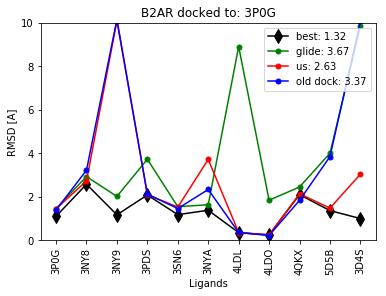

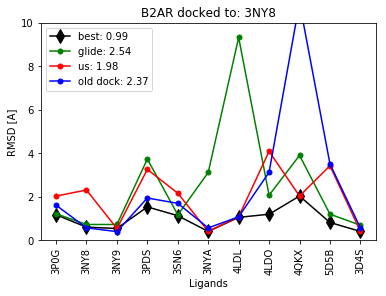

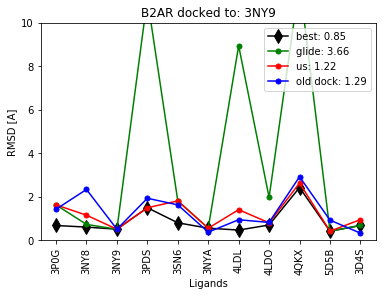

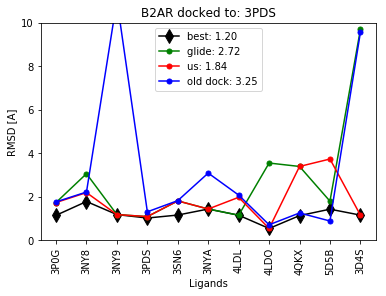

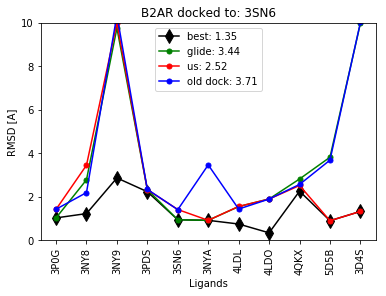

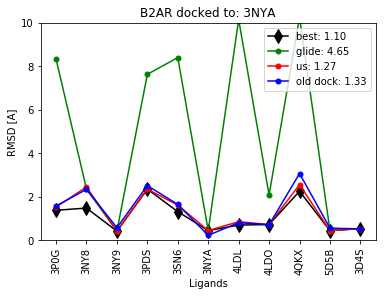

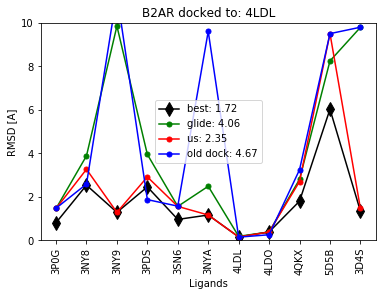

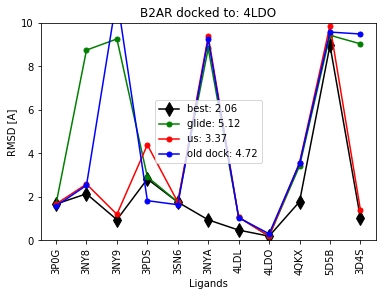

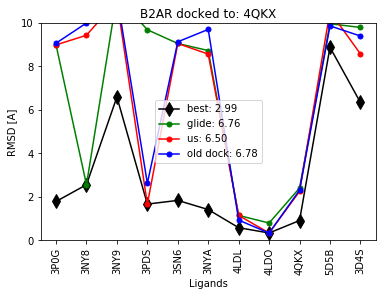

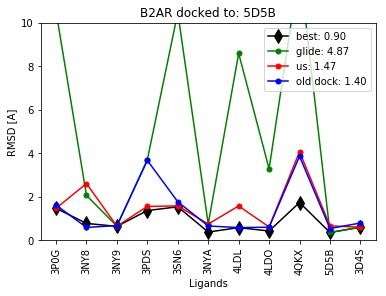

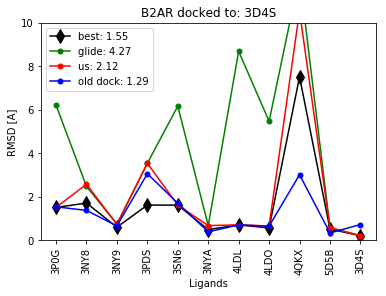

In [3]:
get_ipython().magic(u'matplotlib inline')
datasets = ['B2AR']#'TRMD', 'CDK2', 'CHK1','AR',

for receptor in datasets:
    print receptor
    data_set_dir = '/scratch/PI/rondror/docking_data/'+receptor+'/'
   
    rmsd_file = 'rmsd.csv'
    glide_dir = data_set_dir + 'glide/'
    xglide_dir = data_set_dir + 'xglide/'
    crystal_fp_file = data_set_dir + '/ifp/crystal_ifp_2/ifp.fp'
    docking_fp_dir = data_set_dir + '/ifp/glide_ifp_2/'
    xdocking_fp_dir = data_set_dir + '/ifp/xglide_ifp_2/'
    
    w1 = [10,10,10,1,0]
    (crystals, glides) = load_data(
        data_set_dir, rmsd_file, glide_dir, crystal_fp_file, docking_fp_dir,w=w1)
    (xcrystals, xglides) = load_data(
        data_set_dir, 'xrmsd.csv', xglide_dir, crystal_fp_file, xdocking_fp_dir,w=w1)

    #best_rmsd_matrix = best_pose(glides.keys(), glides.keys(), glides, 50)
    #var_mat = docking_variance(glides.keys(), glides.keys(), glides, 50)
    #print np.nanmean(best_rmsd_matrix)
    #heatmap(best_rmsd_matrix, glides)
    #heatmap(var_mat, glides)

    #best_rmsd_matrix2 = best_pose(xglides.keys(), xglides.keys(), xglides, 25)
    #var_mat2 = docking_variance(xglides.keys(), xglides.keys(), xglides, 25)
    #print np.nanmean(best_rmsd_matrix2)
    #heatmap(best_rmsd_matrix2, xglides)
    #heatmap(var_mat2, xglides)  
    
    for best_structure in glides:
        scores = Scores(glides, crystals, glides.keys(), best_structure, 25)
        scores2 = Scores(xglides, xcrystals, glides.keys(), best_structure, 25)
        final_rmsds = plot_final_rmsds(scores2, receptor+' docked to: '+best_structure, scores,'old dock: ')
    
    #poses, hacks = refine_poses(glides)
    
    #top_poses = [poses[l][0] if len(poses[l])>0 else None for l in poses.keys()]
    #top_pose_rmsds = [i.rmsd if i is not None else 10 for i in top_poses]
    #min_rmsds = [min([i.rmsd if i is not None else 10 for i in poses[l]]) if len(poses[l])>0 else 10.0 for l in poses.keys()]
    
    #fig, ax = plt.subplots()
    
    #plt.plot(top_pose_rmsds, marker='.', markersize=10, color="green",label='glide: '+str(np.mean(top_pose_rmsds))[:4])
    #plt.plot(min_rmsds, marker='d', markersize=10, color="black", label='best: '+str(np.mean(min_rmsds))[:4])
    
    #plt.legend()
    #ax.set_xticklabels(poses.keys(), minor=False, rotation='vertical')
    #ax.set_xticks(np.arange(0,len(poses.keys()),1))
    #plt.gca().set_ylim([0,10])

    #plt.show()
    
    #for lig in glides.keys():
    #    print lig
    #    g1 = [i.gscore for i in poses[lig]]
    #    r1 = [i.rmsd for i in poses[lig]]
        
        #if lig in hacks:
        #    g2 = [i.gscore for i in hacks[lig]]
        #    r2 = [i.rmsd for i in hacks[lig]]
        #    plt.plot(g2, r2, 'r.', markersize=5)
        #plt.plot(g1, r1, 'b.', markersize=5)
        
        #plt.gca().set_ylim([0,16])
        #plt.gca().set_xlim([-15,-4])
        #plt.show()
 